In [2]:
#| default_exp volume
# Diffusion Curvature utils
from diffusion_curvature.kernels import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.datasets import *
from diffusion_curvature.utils import *
# Python necessities
import numpy as np
from fastcore.all import *
import matplotlib.pyplot as plt
# Notebook Helpers
from nbdev.showdoc import *
from tqdm.notebook import trange, tqdm
%load_ext autoreload
%autoreload 2

# Volume Estimation with Heat Diffusion

> TLDR: The self-diffusion method of volume estimation works reliably in sampled euclidean planes of various dimensions. The volume differs from ground truth by a multiplicative factor, but otherwise grows at the same ratio as analytically expected. Be wary, though, of volumes taken at high diffusion times: they vary wildly between samplings. 

In [GitHub - KrishnaswamyLab/HeatGeo: Embedding with the Heat-geodesic dissimilarity](https://github.com/KrishnaswamyLab/HeatGeo), Tong et al use the Chebyshev approximation of the heat equation on the graph to estimate volume, by using Varadhan's formula:

$$
\frac{c(\epsilon)}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{4(1+\epsilon) t}\right) \leq h_t(x, y) \leq \frac{C(\epsilon)}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{4(1-\epsilon) t}\right)
$$

This suggests that the diagonals of the diffusion matrix ($h_t(x,x)$) approximate $\frac{1}{V(x,\sqrt{t})}$. To recover the volume, invert the 'laziness' of the diffusion.

Note that the diffusion times correspond only to the square root of the radius.

In this notebook, we'll implement and experiment on this method of volume estimation, by performing it on several manifolds where the volume is known.

In [3]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.graphs import *
X, ks = torus(2000)
G_torus = get_alpha_decay_graph(X)

In [4]:
#| export
import numpy as np
from diffusion_curvature.utils import kronecker_delta
from diffusion_curvature.heatkernel import expm_multiply, heat_diffusion_on_signal
def volume_via_heat_at_scales(
    G, # a pygsp graph 
    i, # index of point to grow ball from
    ts, # list of times (or single time). 
):
    """Returns a list of volumes of the t-step balls constructed at point i, for each t in ts."""
    x = kronecker_delta(G.L.shape[0],i)
    diffused_at_scales = heat_diffusion_on_signal(G,x, ts) # each signal is a row
    diffused_at_scales = np.array(diffused_at_scales)
    volumes = 1/diffused_at_scales[:,i] # the ith column has the self affinities
    return volumes

In [5]:
volumes_on_torus = volume_via_heat_at_scales(G_torus,0,[2,4,6,8])
volumes_on_torus

array([11.46383275, 16.69535369, 22.80787372, 30.03309658])

# Experiments

## Volume in the ND Euclidean Plane, compared to the actual volume

This is the simplest case. We'll sample euclidean planes of several dimensions, and take volume estimates at various scales. We'll compare those to the real volumes of balls of radii $\sqrt{t}$, by plotting one against the other. 

I suspect that there will be some scaling factor which needs to be estimated, as -- just from the graph -- we don't know what the density is.

In [6]:
from diffusion_curvature.datasets import plane
def volumes_of_euclidean_nplane(
        n_points,
        dim,
        ts
):
    X = plane(n_points,dim)
    G = get_alpha_decay_graph(X)
    vols = volume_via_heat_at_scales(G,0,ts)
    return vols

In [7]:
#| export
from scipy.special import gamma
def actual_euclidean_volumes_at_radii(
        dim,
        radii
):
    vols = []
    for r in radii:
        v = np.pi**(dim/2)/(gamma(dim/2+1))*r**dim
        vols.append(v)
    return np.array(vols)

In [8]:
assert actual_euclidean_volumes_at_radii(2,[4]) == np.pi*4**2

In [9]:
def perform_trials(fn,n_trials=10, **kwargs):
    outs = []
    for i in range(n_trials):
        outs.append(fn(**kwargs))
    return outs

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_arrays(estimated, actual, title=""):
    sns.set(style="darkgrid")  # Set the seaborn style

    # Create a figure and axes
    fig, ax = plt.subplots()

    if estimated.shape[0] > 1:
        # Compute the mean and standard deviation for the estimated array
        mean_estimated = np.mean(estimated, axis=0)
        std_estimated = np.std(estimated, axis=0)

        # Plot estimated as a line with error bars
        ax.errorbar(np.arange(estimated.shape[1]), mean_estimated, yerr=std_estimated, label="Estimated")
    else:
        ax.plot(estimated[0], label="Estimated")
    # Plot actual as a line
    ax.plot(actual, label="Actual")

    # Set the labels for x-axis and y-axis
    ax.set_xlabel("Radius")
    ax.set_ylabel("Volume of n-sphere")

    # Set the title of the plot
    ax.set_title(title)

    # Display the legend
    ax.legend()

    # Show the plot
    plt.show()

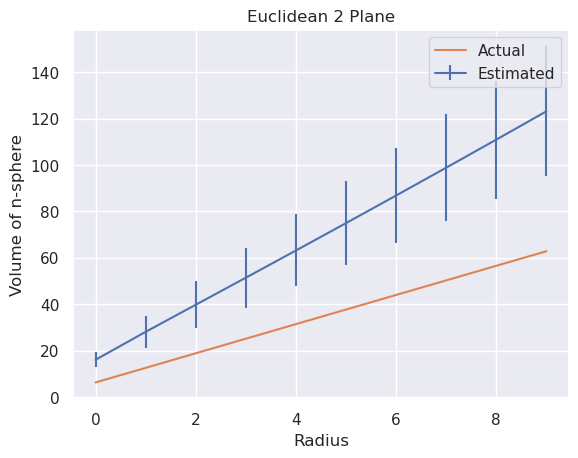

In [11]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 2
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title="Euclidean 2 Plane")


This shows a clear pattern: the volume estimated from residual laziness has 
1. a lot of variation across samplings, especially with higher t values
2. a consistently higher slope than the ground truth, by a constant multiple. 

The second point is consistent with the hypothesis that the unknown density of the graph/point cloud results in a distortion of the volume by some constant factor. Fortunately, when performing a comparison between the manifold space and analytic euclidean space, this factor becomes a constant, reflected only in the linear term of the quadratic approximation, and not in the quadratic term, where scalar curvature is revealed.

The first phenomenon, of increasing variation with increasing radius, is odd. One might expect that large-scale diffusions had the *least* variation between samplings, because it has more time for local fluctuations in density to average out. The opposite appears to be true. At least this supports the use of local approximations.

Let's see what the ratio actually is:

In [12]:
def plot_array(ratios, title=""):
    sns.set(style="darkgrid")  # Set the seaborn style

    # Create a figure and axes
    fig, ax = plt.subplots()
    # Compute the mean and standard deviation for the estimated array
    mean_estimated = np.mean(ratios, axis=0)
    std_estimated = np.std(ratios, axis=0)

    # Plot estimated as a line with error bars
    ax.errorbar(np.arange(ratios.shape[1]), mean_estimated, yerr=std_estimated, label="Estimated")

    # Set the labels for x-axis and y-axis
    ax.set_xlabel("Radius")
    ax.set_ylabel("Volume of n-sphere")

    # Set the title of the plot
    ax.set_title(title)

    # Display the legend
    ax.legend()

    # Show the plot
    plt.show()

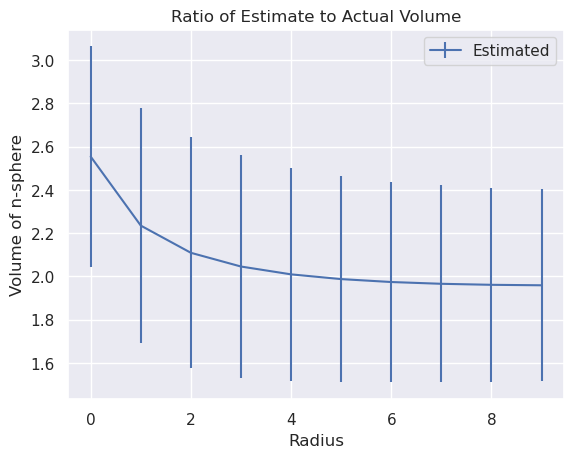

In [13]:
plot_array(heat_estimates/actual_volumes, "Ratio of Estimate to Actual Volume")

Here's the same experiment in higher dimensions.

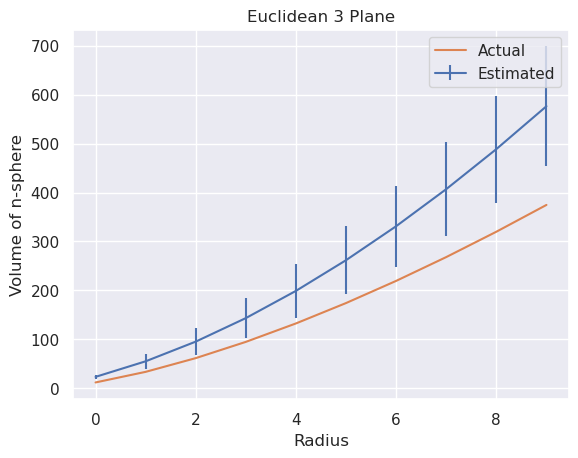

In [14]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 3
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane")


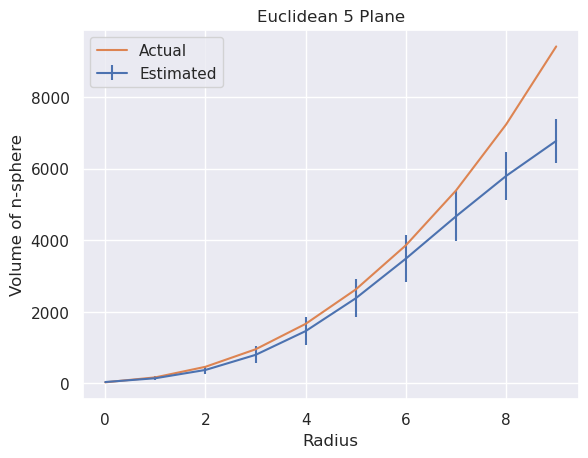

In [15]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 5
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane")


Dimensions 3 and 5 behave as expected, displaying the same patterns of growing more unpredictable with age and varying from ground truth by some multiplicative factor.

With dimension 7, we begin to encounter the curse of dimensionality. 10,000 points is no longer enough; we need something on the order of a million to be able to diffuse for 10-20 steps without hitting edge effects.

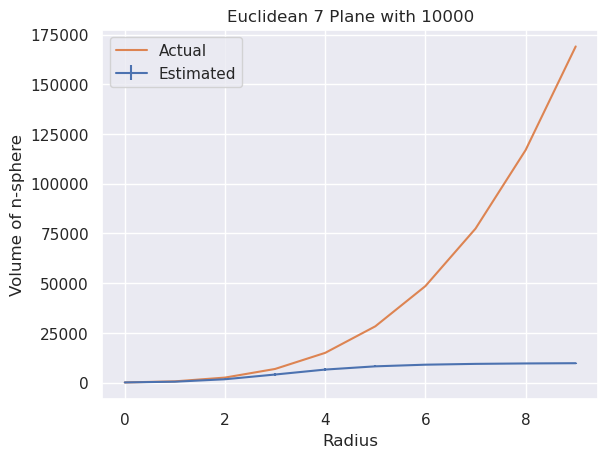

In [16]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 7
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=10, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane with {n_points}")


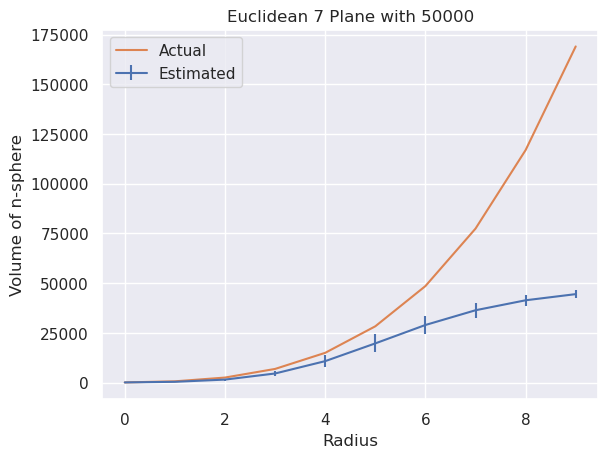

In [17]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 7
n_points=50000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=10, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane with {n_points}")


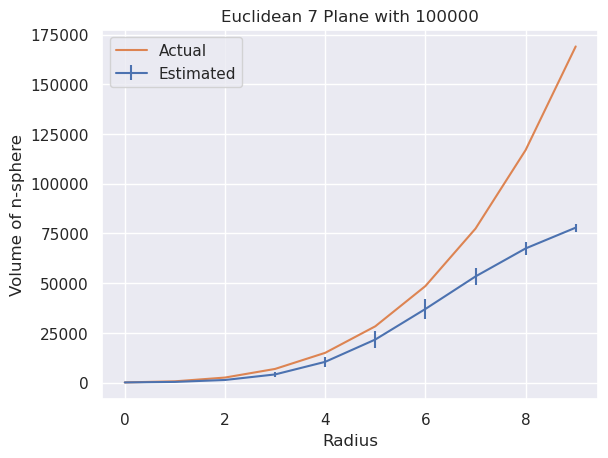

In [18]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 7
n_points=100000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=10, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane with {n_points}")
